In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import numpy as np
import sys
from PIL import Image
from scipy.stats import spearmanr as spr
from scipy.spatial.distance import cosine
import time

In [2]:
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from captum.attr import Saliency, IntegratedGradients, LRP, GuidedBackprop, NoiseTunnel, GuidedGradCam, InputXGradient, DeepLift
from captum.attr import visualization as viz

In [4]:
sys.path.append("../attacks/")
from utils import get_expl, torch_to_image, load_image,  convert_relu_to_softplus, heatmap_to_image
import mister_ed.utils.pytorch_utils as mister_ed_utils

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [6]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

In [11]:
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])
# x = load_image(data_mean, data_std, device, "../../explanations_can_be_manipulated/data/collie4.jpeg")
# plt.imshow(torch_to_image(x, data_mean, data_std))
# plt.axis('off')
# plt.savefig("Original_image", dpi=300, bbox_inches='tight', pad_inches=0.05)

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


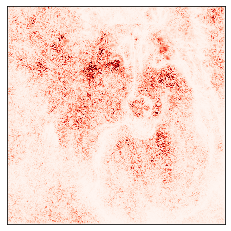

(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f23d7dc5590>)

In [8]:
x_expl_grad = get_expl(model, x, "saliency", normalize=True, multiply_by_input=True)
viz.visualize_image_attr(np.transpose(x_expl_grad.cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4))


In [11]:
y_mesh, x_mesh = np.meshgrid(np.arange(224),np.arange(224))
y_mesh, x_mesh = torch.Tensor(y_mesh).unsqueeze(0).to(device), torch.Tensor(x_mesh).unsqueeze(0).to(device)
org_expl_mass_center = [int(torch.sum(x_expl_grad*x_mesh)), int(torch.sum(x_expl_grad*y_mesh))]

In [12]:
org_expl_mass_center

[98, 106]

### for more images

In [12]:
np.random.seed(72)
torch.manual_seed(72)
torch.cuda.manual_seed(72)

In [13]:
normalizer = mister_ed_utils.DifferentiableNormalize(mean=data_mean,
                                               std=data_std)

In [14]:
trasform_imagenet = transforms.Compose([transforms.Resize(256),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor()])

imagenet_val = torchvision.datasets.ImageNet(root="./data/", split="val", transform=trasform_imagenet)

test_loader = torch.utils.data.DataLoader(
        imagenet_val,
        batch_size=1024,
        shuffle=True
    )

In [15]:
a = np.random.randint(1024, size=4)

In [16]:
a

array([472, 787,  46,  74])

In [17]:
dataiter = iter(test_loader)

tensor([454, 342, 385, 629])


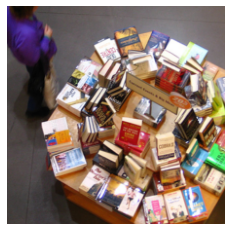

In [19]:
images, labels = next(dataiter)
x = normalizer.forward(images[a]).to(device)
print(labels[a])
plt.imshow(torch_to_image(x[0:1], data_mean, data_std))
plt.axis('off');

tensor([767, 823,  44, 657])


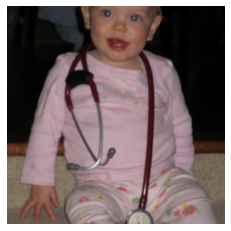

In [20]:
images_target, labels_target = next(dataiter)
x_target = normalizer.forward(images_target[a]).to(device)
print(labels_target[a])
plt.imshow(torch_to_image(x_target[1:2], data_mean, data_std))
plt.axis('off');

In [21]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

In [17]:
sigma = tuple((torch.max(x[i]) - torch.min(x[i])).item() * 0.2 for i in range(x.size()[0]))
print(sigma)

(0.948094940185547, 0.8471883773803711, 0.9273017883300781, 0.9132366180419922)


In [18]:
x_expl_grad = get_expl(model, x, "saliency", desired_index=labels[a].to(device), normalize=True)
# x_expl_grad_target = get_expl(model, x_target, "saliency", desired_index=labels_target[a].to(device), normalize=True)

In [19]:
x_expl_grad.size()

torch.Size([4, 1, 224, 224])

In [35]:
x_expl_grad_input = get_expl(model, x, "input_times_grad", desired_index=labels[a].to(device), normalize=True)
x_expl_grad_input_target = get_expl(model, x_target, "input_times_grad", desired_index=labels_target[a].to(device), normalize=True)

/home/ubuntu/anaconda3/envs/pytorch19_p37/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


In [36]:
F.mse_loss(x_expl_grad, x_expl_grad_target)

tensor(9.8246e-10, device='cuda:0', grad_fn=<MseLossBackward>)

In [37]:
F.mse_loss(x_expl_grad_input, x_expl_grad_input_target)

tensor(0.6507, device='cuda:0', grad_fn=<MseLossBackward>)

(<Figure size 432x216 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f442856c6d0>)

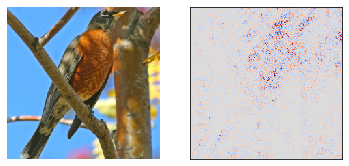

In [30]:
fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(torch_to_image(x[1:2], data_mean, data_std))
ax[0].axis('off')
viz.visualize_image_attr(np.transpose(x_expl_grad[1:2].squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x[1:2].squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             outlier_perc=2,
                             sign="all",
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1]), use_pyplot=False)


In [18]:
F.mse_loss(F.softmax(model(x), dim=1), F.softmax(model(x), dim=1))

tensor(0., device='cuda:0', grad_fn=<MseLossBackward>)

In [19]:
import scipy.spatial as spatial
spatial.distance.cosine

<function scipy.spatial.distance.cosine(u, v, w=None)>

### Gradient norm

In [112]:
grad_norms = []
sg_norms = []
ug_norms = []
beta_smoothing_norms = []
i = 0
while i < 10:
    model = torchvision.models.vgg16(pretrained=True).to(device)
    model = model.eval()
    a = np.random.randint(256)
    x = normalizer.forward(images[a].unsqueeze(0)).to(device)
    idx = model(x).argmax()
    if idx == labels[a]:
        print(labels[a])
        print(idx)
        i = i+1
    else:
        continue
    sigma = (torch.max(x) - torch.min(x)).item() * 0.2
    ######
    x_expl_grad = get_expl(model, x, "saliency", desired_index=idx, abs_value=False).detach().cpu()
    grad_norms.append(torch.norm(x_expl_grad))
    x_expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma, abs_value=False).detach().cpu()
    sg_norms.append(torch.norm(x_expl_sg))
    x_expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma, abs_value=False).detach().cpu()
    ug_norms.append(torch.norm(x_expl_ug))
    ##
    model = convert_relu_to_softplus(model, beta=0.8)
    x_expl_softplus = get_expl(model, x, "saliency", desired_index=idx, abs_value=False).detach().cpu()
    beta_smoothing_norms.append(torch.norm(x_expl_softplus))
    ######
    del x_expl_grad
    del x_expl_sg
    del x_expl_ug
    del x_expl_softplus
    torch.cuda.empty_cache()
    

tensor(484)
tensor(484, device='cuda:0')
tensor(281)
tensor(281, device='cuda:0')
tensor(795)
tensor(795, device='cuda:0')
tensor(276)
tensor(276, device='cuda:0')
tensor(903)
tensor(903, device='cuda:0')
tensor(556)
tensor(556, device='cuda:0')
tensor(156)
tensor(156, device='cuda:0')
tensor(2)
tensor(2, device='cuda:0')
tensor(231)
tensor(231, device='cuda:0')
tensor(939)
tensor(939, device='cuda:0')


In [113]:
print("gradient: ", np.mean(grad_norms))
print("smooth gradient: ", np.mean(sg_norms))
print("uniform gradient: ", np.mean(ug_norms))
print(r"$\beta$-smoothing: ", np.mean(beta_smoothing_norms))

gradient:  11.262938
smooth gradient:  0.7879091
uniform gradient:  1.6969239
$\beta$-smoothing:  0.45461816


### Cascade randomization of layers

tensor([345])


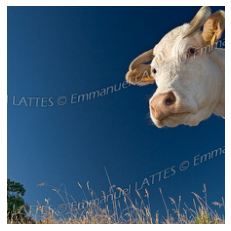

In [24]:
a = np.random.randint(1024, size=1)
x = normalizer.forward(images[a]).to(device)
print(labels[a])
plt.imshow(torch_to_image(x, data_mean, data_std))
plt.axis('off');
plt.savefig("temp_image.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

In [25]:
sigma = (torch.max(x) - torch.min(x)).item() * 0.2 
sigma

0.9202083587646485

tensor(345, device='cuda:0')


/home/ahmad/anaconda3/envs/pytorch_robust_expls/lib/python3.9/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/ahmad/anaconda3/envs/pytorch_robust_expls/lib/python3.9/site-packages/captum/attr/_utils/visualization.py:44: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  warnings.warn(


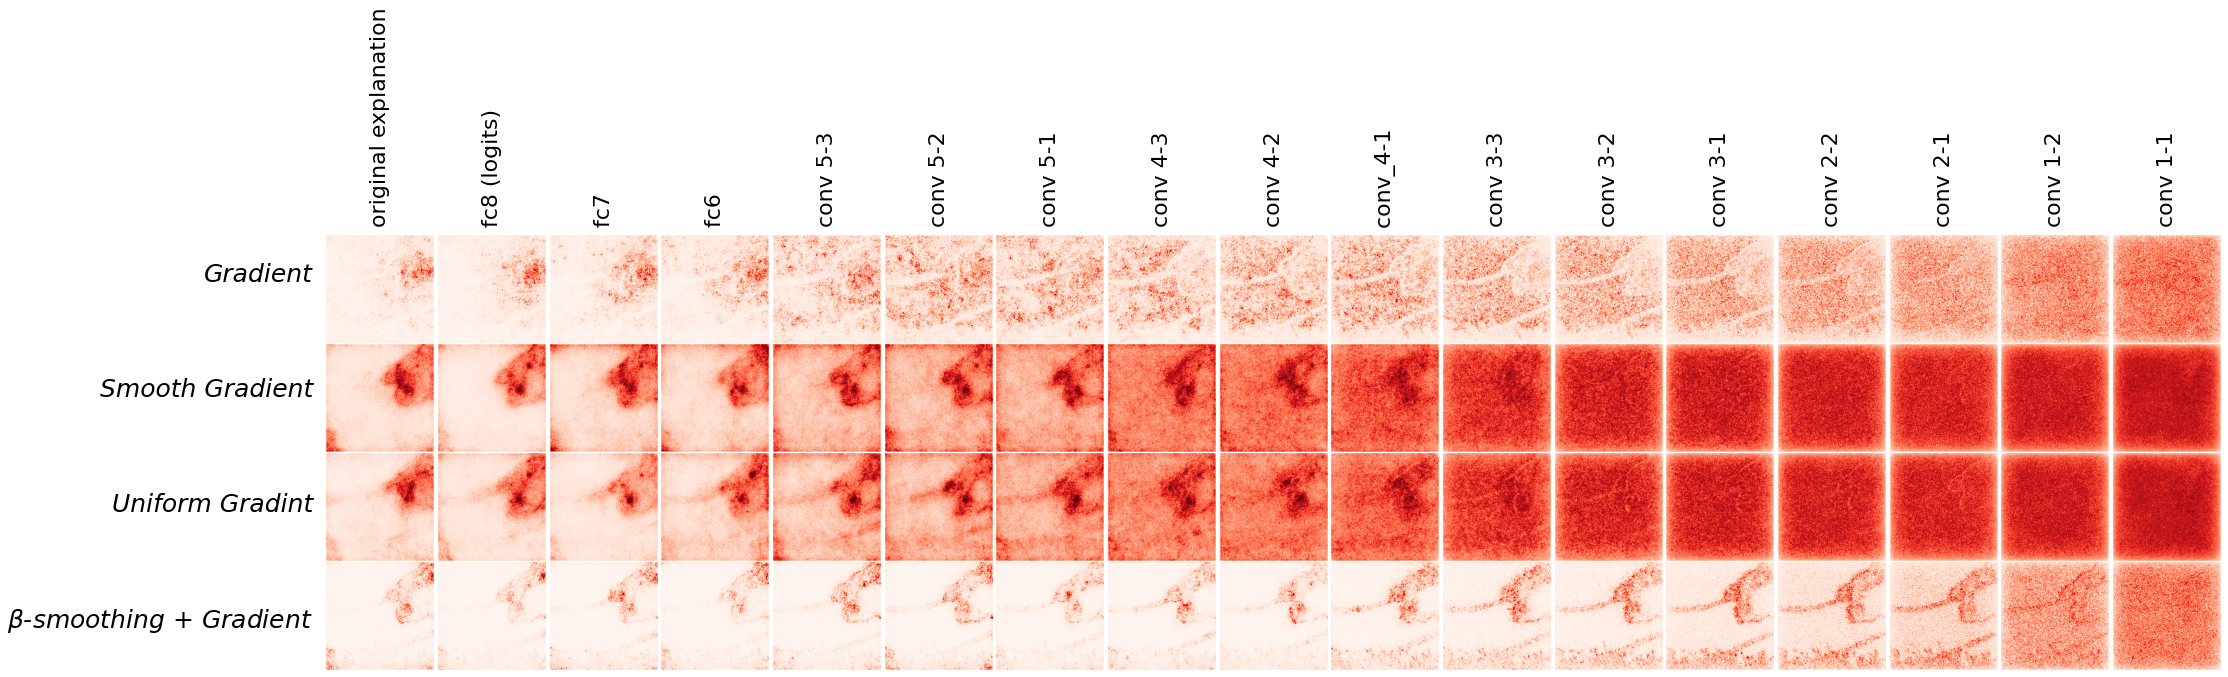

In [26]:
# cascade

layer_names = ["conv 1-1", "conv 1-2", "conv 2-1", "conv 2-2", 
              "conv 3-1", "conv 3-2", "conv 3-3",
              "conv_4-1", "conv 4-2", "conv 4-3",
              "conv 5-1", "conv 5-2", "conv 5-3",
              "fc6", "fc7", "fc8 (logits)", "original explanation"]
layer_names = layer_names[::-1]

model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

idx = model(x).argmax()
print(idx)


x_expl_grad = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
x_expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
x_expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
torch.cuda.empty_cache()

fig, ax = plt.subplots(4, 17, figsize=(34, 8))
viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[0, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, 0]), use_pyplot=False)

org_layers_to_reinit = []
# softplus_layers_to_reinit = []

for i in range(len(model.features)):
    if isinstance(model.features[i], nn.Conv2d):
        org_layers_to_reinit.append(model.features[i])
    elif isinstance(model.features[i], nn.Linear):
        org_layers_to_reinit.append(model.features[i])
    else: pass
    
for i in range(len(model.classifier)):
    if isinstance(model.classifier[i], nn.Conv2d):
        org_layers_to_reinit.append(model.classifier[i])
    elif isinstance(model.classifier[i], nn.Linear):
        org_layers_to_reinit.append(model.classifier[i])
    else: pass
org_layers_to_reinit = org_layers_to_reinit[::-1]

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_grad = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
    x_expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
    x_expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()

    viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[0, i+1]), use_pyplot=False)

    viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, i+1]), use_pyplot=False)
    
    viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, i+1]), use_pyplot=False)
    del x_expl_grad
    del x_expl_sg
    del x_expl_ug
    torch.cuda.empty_cache()

############softplus###########################
model = torchvision.models.vgg16(pretrained=True).to(device)
model = convert_relu_to_softplus(model, beta=0.8)

org_layers_to_reinit = []
# softplus_layers_to_reinit = []

for i in range(len(model.features)):
    if isinstance(model.features[i], nn.Conv2d):
        org_layers_to_reinit.append(model.features[i])
    elif isinstance(model.features[i], nn.Linear):
        org_layers_to_reinit.append(model.features[i])
    else: pass
    
for i in range(len(model.classifier)):
    if isinstance(model.classifier[i], nn.Conv2d):
        org_layers_to_reinit.append(model.classifier[i])
    elif isinstance(model.classifier[i], nn.Linear):
        org_layers_to_reinit.append(model.classifier[i])
    else: pass
org_layers_to_reinit = org_layers_to_reinit[::-1]

x_expl_softplus = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
torch.cuda.empty_cache()
viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[3, 0]), use_pyplot=False)

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_softplus = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
    viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[3, i+1]), use_pyplot=False)
    del x_expl_softplus
    torch.cuda.empty_cache()
    
    
for i in range(17):
    ax[0, i].set_title(" "+layer_names[i], fontsize=22, rotation=90)
for i in range(4): 
    for j in range(17):
        ax[i,j].axis('off')
fig.text(0.12, 0.8, 'Gradient', style = 'oblique', fontsize = 25, horizontalalignment ='right')
fig.text(0.12, 0.6, 'Smooth Gradient', style = 'oblique', fontsize = 25, horizontalalignment ='right')
fig.text(0.12, 0.4, 'Uniform Gradint', style = 'oblique', fontsize = 25, horizontalalignment ='right')
fig.text(0.12, 0.2, r'$\beta$-smoothing + Gradient', style = 'oblique', fontsize = 25, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("expls_cascade_randomized.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

#### comparing with spr values

In [20]:
np.random.seed(seed=93)
torch.random.manual_seed(seed=93)
torch.cuda.random.manual_seed(seed=93)
dataiter = iter(test_loader)

In [ ]:
spr_grad_all = []
spr_smooth_grad_all = []
spr_uniform_grad_all = []
spr_softplus_all = []

dataiter = iter(test_loader)

for num_img in range(100):
    images, labels = next(dataiter)
    a = np.random.randint(256)
    x = normalizer.forward(images[a:a+1]).to(device)
    sigma = (torch.max(x) - torch.min(x)).item() * 0.2 
    
    model = torchvision.models.vgg16(pretrained=True).to(device)
    model = model.eval()

    idx = model(x).argmax()
    if num_img%5 == 0:
        print(idx)


    x_expl_grad_org = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
    x_expl_sg_org = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
    x_expl_ug_org = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
    torch.cuda.empty_cache()


    org_layers_to_reinit = []
    # softplus_layers_to_reinit = []

    for i in range(len(model.features)):
        if isinstance(model.features[i], nn.Conv2d):
            org_layers_to_reinit.append(model.features[i])
        elif isinstance(model.features[i], nn.Linear):
            org_layers_to_reinit.append(model.features[i])
        else: pass

    for i in range(len(model.classifier)):
        if isinstance(model.classifier[i], nn.Conv2d):
            org_layers_to_reinit.append(model.classifier[i])
        elif isinstance(model.classifier[i], nn.Linear):
            org_layers_to_reinit.append(model.classifier[i])
        else: pass
    org_layers_to_reinit = org_layers_to_reinit[::-1]

    # SPR VALUES
    spr_grad = [1.0]
    spr_smooth_grad = [1.0]
    spr_uniform_grad = [1.0]
    spr_softplus = [1.0]

    for i, l in enumerate(org_layers_to_reinit):
        nn.init.xavier_uniform_(l.weight)
        x_expl_grad = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
        spr_grad.append(spr(x_expl_grad_org.flatten(), x_expl_grad.flatten())[0])
        del x_expl_grad
        torch.cuda.empty_cache()
        ##
        x_expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
        spr_smooth_grad.append(spr(x_expl_sg_org.flatten(), x_expl_sg.flatten())[0])
        del x_expl_sg
        torch.cuda.empty_cache()
        ##
        x_expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
        spr_uniform_grad.append(spr(x_expl_ug_org.flatten(), x_expl_ug.flatten())[0])
        del x_expl_ug
        torch.cuda.empty_cache()
    

    ############softplus###########################
    model = torchvision.models.vgg16(pretrained=True).to(device)
    model = convert_relu_to_softplus(model, beta=0.8)

    org_layers_to_reinit = []
    # softplus_layers_to_reinit = []

    for i in range(len(model.features)):
        if isinstance(model.features[i], nn.Conv2d):
            org_layers_to_reinit.append(model.features[i])
        elif isinstance(model.features[i], nn.Linear):
            org_layers_to_reinit.append(model.features[i])
        else: pass

    for i in range(len(model.classifier)):
        if isinstance(model.classifier[i], nn.Conv2d):
            org_layers_to_reinit.append(model.classifier[i])
        elif isinstance(model.classifier[i], nn.Linear):
            org_layers_to_reinit.append(model.classifier[i])
        else: pass
    org_layers_to_reinit = org_layers_to_reinit[::-1]

    x_expl_softplus_org = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()

    for i, l in enumerate(org_layers_to_reinit):
        nn.init.xavier_uniform_(l.weight)
        x_expl_softplus = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
        spr_softplus.append(spr(x_expl_softplus_org.flatten(), x_expl_softplus.flatten())[0])
        del x_expl_softplus
        torch.cuda.empty_cache()
    #######
    spr_grad_all.append(spr_grad)
    spr_smooth_grad_all.append(spr_smooth_grad)
    spr_uniform_grad_all.append(spr_uniform_grad)
    spr_softplus_all.append(spr_softplus)


tensor(841, device='cuda:0')
tensor(924, device='cuda:0')


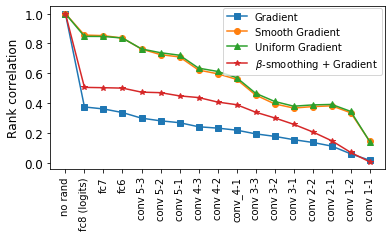

In [25]:
plt.figure(figsize=(6, 3))
plt.plot(np.mean(np.array(spr_grad_all), axis=0), label="Gradient", marker="s")
plt.plot(np.mean(np.array(spr_smooth_grad_all), axis=0), label="Smooth Gradient", marker="o")
plt.plot(np.mean(np.array(spr_uniform_grad_all), axis=0), label="Uniform Gradient", marker="^")
plt.plot(np.mean(np.array(spr_softplus_all), axis=0), label=r"$\beta$-smoothing + Gradient", marker="*")
plt.legend(bbox_to_anchor=(0.5, 0.55))
plt.xticks(range(17), ["no rand"] + layer_names[1:], rotation=90);
plt.ylabel("Rank correlation", fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("spr_cascade_randomized.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

#### without abs value

tensor(17, device='cuda:0')


/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/captum/attr/_utils/visualization.py:45: UserWarning: Attempting to normalize by value approximately 0, visualized resultsmay be misleading. This likely means that attribution values are allclose to 0.
  "Attempting to normalize by value approximately 0, visualized results"


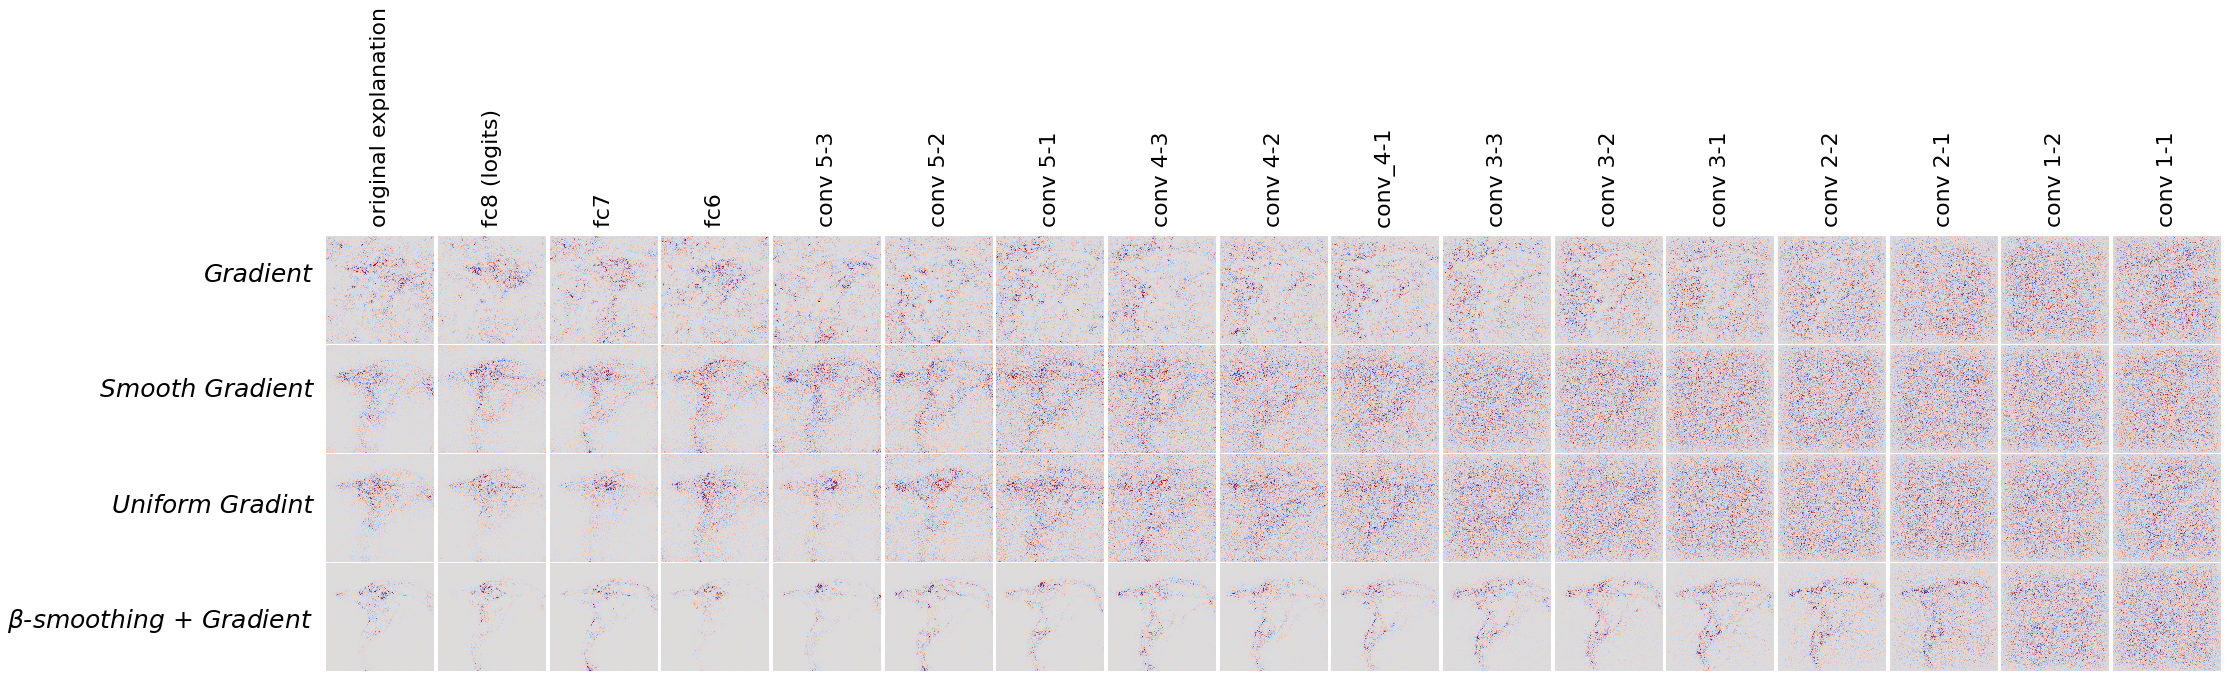

In [121]:
# cascade

layer_names = ["conv 1-1", "conv 1-2", "conv 2-1", "conv 2-2", 
              "conv 3-1", "conv 3-2", "conv 3-3",
              "conv_4-1", "conv 4-2", "conv 4-3",
              "conv 5-1", "conv 5-2", "conv 5-3",
              "fc6", "fc7", "fc8 (logits)", "original explanation"]
layer_names = layer_names[::-1]

model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

idx = model(x).argmax()
print(idx)


x_expl_grad = get_expl(model, x, "saliency", desired_index=idx, abs_value=False).detach().cpu()
x_expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma, abs_value=False).detach().cpu()
x_expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma, abs_value=False).detach().cpu()
torch.cuda.empty_cache()

fig, ax = plt.subplots(4, 17, figsize=(34, 8))
viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[0, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, 0]), use_pyplot=False)

org_layers_to_reinit = []
# softplus_layers_to_reinit = []

for i in range(len(model.features)):
    if isinstance(model.features[i], nn.Conv2d):
        org_layers_to_reinit.append(model.features[i])
    elif isinstance(model.features[i], nn.Linear):
        org_layers_to_reinit.append(model.features[i])
    else: pass
    
for i in range(len(model.classifier)):
    if isinstance(model.classifier[i], nn.Conv2d):
        org_layers_to_reinit.append(model.classifier[i])
    elif isinstance(model.classifier[i], nn.Linear):
        org_layers_to_reinit.append(model.classifier[i])
    else: pass
org_layers_to_reinit = org_layers_to_reinit[::-1]

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_grad = get_expl(model, x, "saliency", desired_index=idx, abs_value=False).detach().cpu()
    x_expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma, abs_value=False).detach().cpu()
    x_expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma, abs_value=False).detach().cpu()

    viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[0, i+1]), use_pyplot=False)

    viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, i+1]), use_pyplot=False)
    
    viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, i+1]), use_pyplot=False)
    del x_expl_grad
    del x_expl_sg
    del x_expl_ug
    torch.cuda.empty_cache()

############softplus###########################
model = torchvision.models.vgg16(pretrained=True).to(device)
model = convert_relu_to_softplus(model, beta=0.8)

org_layers_to_reinit = []
# softplus_layers_to_reinit = []

for i in range(len(model.features)):
    if isinstance(model.features[i], nn.Conv2d):
        org_layers_to_reinit.append(model.features[i])
    elif isinstance(model.features[i], nn.Linear):
        org_layers_to_reinit.append(model.features[i])
    else: pass
    
for i in range(len(model.classifier)):
    if isinstance(model.classifier[i], nn.Conv2d):
        org_layers_to_reinit.append(model.classifier[i])
    elif isinstance(model.classifier[i], nn.Linear):
        org_layers_to_reinit.append(model.classifier[i])
    else: pass
org_layers_to_reinit = org_layers_to_reinit[::-1]

x_expl_softplus = get_expl(model, x, "saliency", desired_index=idx, abs_value=False).detach().cpu()
torch.cuda.empty_cache()
viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[3, 0]), use_pyplot=False)

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_softplus = get_expl(model, x, "saliency", desired_index=idx, abs_value=False).detach().cpu()
    viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[3, i+1]), use_pyplot=False)
    del x_expl_softplus
    torch.cuda.empty_cache()
    
    
for i in range(17):
    ax[0, i].set_title(" "+layer_names[i], fontsize=22, rotation=90)
for i in range(4): 
    for j in range(17):
        ax[i,j].axis('off')
fig.text(0.12, 0.8, 'Gradient', style = 'oblique', fontsize = 25, horizontalalignment ='right')
fig.text(0.12, 0.6, 'Smooth Gradient', style = 'oblique', fontsize = 25, horizontalalignment ='right')
fig.text(0.12, 0.4, 'Uniform Gradint', style = 'oblique', fontsize = 25, horizontalalignment ='right')
fig.text(0.12, 0.2, r'$\beta$-smoothing + Gradient', style = 'oblique', fontsize = 25, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("expls_cascade_randomized_no_abs.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

In [122]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

idx = model(x).argmax()
print(idx)


x_expl_grad_org = get_expl(model, x, "saliency", desired_index=idx, abs_value=False).detach().cpu()
x_expl_sg_org = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma, abs_value=False).detach().cpu()
x_expl_ug_org = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma, abs_value=False).detach().cpu()
torch.cuda.empty_cache()


org_layers_to_reinit = []
# softplus_layers_to_reinit = []

for i in range(len(model.features)):
    if isinstance(model.features[i], nn.Conv2d):
        org_layers_to_reinit.append(model.features[i])
    elif isinstance(model.features[i], nn.Linear):
        org_layers_to_reinit.append(model.features[i])
    else: pass
    
for i in range(len(model.classifier)):
    if isinstance(model.classifier[i], nn.Conv2d):
        org_layers_to_reinit.append(model.classifier[i])
    elif isinstance(model.classifier[i], nn.Linear):
        org_layers_to_reinit.append(model.classifier[i])
    else: pass
org_layers_to_reinit = org_layers_to_reinit[::-1]

# SPR VALUES
spr_grad = [1.0]
spr_smooth_grad = [1.0]
spr_uniform_grad = [1.0]
spr_softplus = [1.0]

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_grad = get_expl(model, x, "saliency", desired_index=idx, abs_value=False).detach().cpu()
    spr_grad.append(spr(x_expl_grad_org.flatten(), x_expl_grad.flatten())[0])
    del x_expl_grad
    torch.cuda.empty_cache()
    ##
    x_expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma, abs_value=False).detach().cpu()
    spr_smooth_grad.append(spr(x_expl_sg_org.flatten(), x_expl_sg.flatten())[0])
    del x_expl_sg
    torch.cuda.empty_cache()
    ##
    x_expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma, abs_value=False).detach().cpu()
    spr_uniform_grad.append(spr(x_expl_ug_org.flatten(), x_expl_ug.flatten())[0])
    del x_expl_ug
    torch.cuda.empty_cache()
    

############softplus###########################
model = torchvision.models.vgg16(pretrained=True).to(device)
model = convert_relu_to_softplus(model, beta=100.0)

org_layers_to_reinit = []

for i in range(len(model.features)):
    if isinstance(model.features[i], nn.Conv2d):
        org_layers_to_reinit.append(model.features[i])
    elif isinstance(model.features[i], nn.Linear):
        org_layers_to_reinit.append(model.features[i])
    else: pass
    
for i in range(len(model.classifier)):
    if isinstance(model.classifier[i], nn.Conv2d):
        org_layers_to_reinit.append(model.classifier[i])
    elif isinstance(model.classifier[i], nn.Linear):
        org_layers_to_reinit.append(model.classifier[i])
    else: pass
org_layers_to_reinit = org_layers_to_reinit[::-1]

x_expl_softplus_org = get_expl(model, x, "saliency", desired_index=idx, abs_value=False).detach().cpu()

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_softplus = get_expl(model, x, "saliency", desired_index=idx, abs_value=False).detach().cpu()
    spr_softplus.append(spr(x_expl_softplus_org.flatten(), x_expl_softplus.flatten())[0])
    del x_expl_softplus
    torch.cuda.empty_cache()


tensor(17, device='cuda:0')


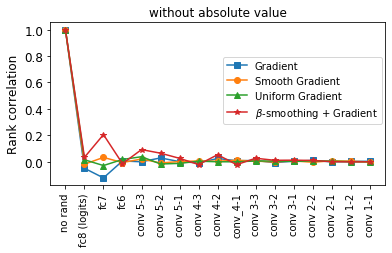

In [127]:
plt.figure(figsize=(6, 3))
plt.plot(spr_grad, label="Gradient", marker="s")
plt.plot(spr_smooth_grad, label="Smooth Gradient", marker="o")
plt.plot(spr_uniform_grad, label="Uniform Gradient", marker="^")
plt.plot(spr_softplus, label=r"$\beta$-smoothing + Gradient", marker="*")
plt.legend(bbox_to_anchor=(0.5, 0.82))
plt.xticks(range(17), ["no rand"] + layer_names[1:], rotation=90);
plt.ylabel("Rank correlation", fontsize=12)
plt.yticks(fontsize=12)
plt.title("without absolute value")
plt.savefig("spr_cascade_randomized_no_abs.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

#### comparing $\sigma$ values for smooth grad

In [ ]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

idx = model(x).argmax()
print(idx)

sigmas = [(torch.max(x) - torch.min(x)).item() * c for c in [0.01, 0.05, 0.1, 0.2,]]
spr_rank_grad = [1.0]
spr_rank_smooth_grad = {sigma:[1.0] for sigma in sigmas}

x_expl_grad_org = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
x_expl_sg_org = {sigma: get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu() 
                 for sigma in sigmas}
torch.cuda.empty_cache()

org_layers_to_reinit = []

for i in range(len(model.features)):
    if isinstance(model.features[i], nn.Conv2d):
        org_layers_to_reinit.append(model.features[i])
    elif isinstance(model.features[i], nn.Linear):
        org_layers_to_reinit.append(model.features[i])
    else: pass
    
for i in range(len(model.classifier)):
    if isinstance(model.classifier[i], nn.Conv2d):
        org_layers_to_reinit.append(model.classifier[i])
    elif isinstance(model.classifier[i], nn.Linear):
        org_layers_to_reinit.append(model.classifier[i])
    else: pass
org_layers_to_reinit = org_layers_to_reinit[::-1]

for i, l in enumerate(org_layers_to_reinit):
    nn.init.xavier_uniform_(l.weight)
    x_expl_grad = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
    spr_rank_grad.append(spr(x_expl_grad_org.flatten(), 
                             x_expl_grad.flatten())[0])
    del x_expl_grad
    torch.cuda.empty_cache()
    for sigma in sigmas:
        x_expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
        spr_rank_smooth_grad[sigma].append(spr(x_expl_sg_org[sigma].flatten(),
                                              x_expl_sg.flatten())[0])
        del x_expl_sg
        torch.cuda.empty_cache()
    
    
    


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(spr_rank_grad, label="saliency", marker="s")
for s in sigmas:
    plt.plot(spr_rank_smooth_grad[s], label="smooth grad, $\sigma$={}".format(round(s, 2)), marker="o")
plt.legend()
plt.xticks(range(17), layer_names, rotation=90);
plt.savefig("spr_cascade_randomized_sg.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

### checker board examples

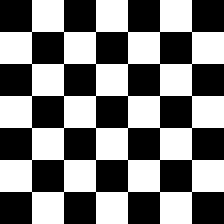

In [11]:
chess = Image.open("checkerboard.png")
chess

In [12]:
x_chess = torchvision.transforms.ToTensor()(chess).unsqueeze(0).to(device)

In [64]:
a = np.random.randint(256)
x = normalizer.forward(images[a].unsqueeze(0)).to(device)
print(labels[a])

tensor(643)


In [59]:
# x = load_image(data_mean, data_std, device, "../sample_imagenet/sample_0.jpg")

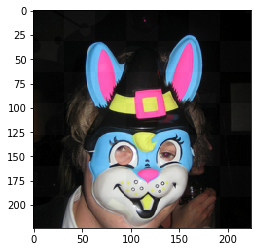

In [65]:
plt.imshow(torch_to_image(x+0.1*x_chess, data_mean, data_std))

In [66]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

In [69]:
model(x+1.5*x_chess).argmax()

tensor(643, device='cuda:0')

In [15]:
sigma = (torch.max(x) - torch.min(x)).item() * 0.2
sigma

0.8506741523742676

In [16]:
corr_grad = []
corr_sg = []
corr_ug = []
corr_beta = []

tensor(205, device='cuda:0')


/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


tensor(205, device='cuda:0')


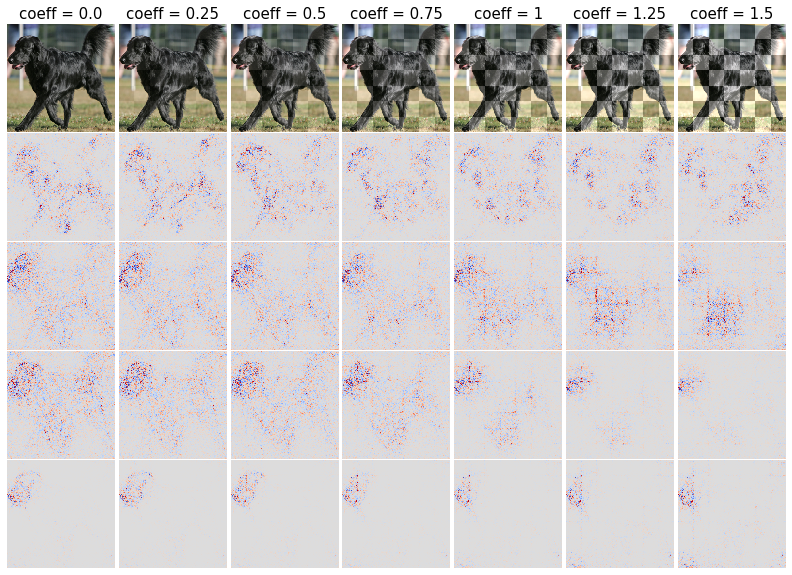

In [17]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()
idx = model(x).argmax()
print(idx)

#######
np.random.seed(seed=2)
torch.random.manual_seed(seed=2)
torch.cuda.random.manual_seed(seed=2)
expl_grad = get_expl(model, x, "saliency", desired_index=idx, abs_value=False).detach().cpu()
expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma, abs_value=False).detach().cpu()
expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma, abs_value=False).detach().cpu()
#######
fig, ax = plt.subplots(5, 7, figsize=(14,10))
for i, c in enumerate([0.0, 0.25, 0.5, .75, 1, 1.25, 1.5]):
    np.random.seed(seed=1)
    torch.random.manual_seed(seed=1)
    torch.cuda.random.manual_seed(seed=1)
    ax[0, i].imshow(torch_to_image(x+c*x_chess, data_mean, data_std))
    x_expl_grad = get_expl(model, x+c*x_chess, "saliency", desired_index=idx, abs_value=False).detach().cpu()
    x_expl_sg = get_expl(model, x+c*x_chess, "saliency", desired_index=idx, smooth=True, sigma=sigma, abs_value=False).detach().cpu()
    x_expl_ug = get_expl(model, x+c*x_chess, "uniform_grad", desired_index=idx, sigma=sigma, abs_value=False).detach().cpu()
    
    viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, i]), use_pyplot=False)
    corr_grad.append(spr(expl_grad.flatten(), x_expl_grad.flatten())[0])
    del x_expl_grad
    viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, i]), use_pyplot=False)
    corr_sg.append(spr(expl_sg.flatten(), x_expl_sg.flatten())[0])
    del x_expl_sg
    viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[3, i]), use_pyplot=False)
    corr_ug.append(spr(expl_ug.flatten(), x_expl_ug.flatten())[0])
    del x_expl_ug
    torch.cuda.empty_cache()
print(model(x+c*x_chess).argmax())
########softplus###########
model = convert_relu_to_softplus(model, beta=0.8)
######
expl_softplus = get_expl(model, x, "saliency", desired_index=idx, abs_value=False).detach().cpu()
######
for i, c in enumerate([0.0, 0.25, 0.5, .75, 1, 1.25, 1.5]):
    x_expl_softplus = get_expl(model, x+c*x_chess, "saliency", desired_index=idx, abs_value=False).detach().cpu()
    viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[4, i]), use_pyplot=False)
    corr_beta.append(spr(expl_softplus.flatten(), x_expl_softplus.flatten())[0])
    del x_expl_softplus
    torch.cuda.empty_cache()
for i, c in enumerate([0.0, 0.25, 0.5, .75, 1, 1.25, 1.5]):
    ax[0, i].set_title("coeff = {}".format(c), fontsize=15)
for i in range(5):
    for j in range(7):
        ax[i,j].axis('off')
# fig.text(0.12, 0.66, 'Saliency', style = 'oblique', fontsize = 15, horizontalalignment ='right')
# fig.text(0.12, 0.5, 'Smooth Grad', style = 'oblique', fontsize = 15, horizontalalignment ='right')
# fig.text(0.12, 0.35, 'Uniform Grad', style = 'oblique', fontsize = 15, horizontalalignment ='right')
# fig.text(0.12, 0.2, 'Softplus', style = 'oblique', fontsize = 15, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("checkerboard_1.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05)

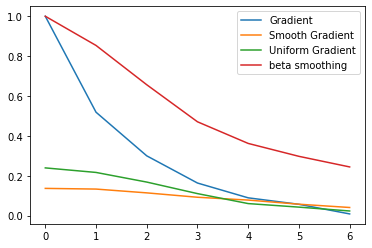

In [18]:
plt.plot(corr_grad, label="Gradient")
plt.plot(corr_sg, label="Smooth Gradient")
plt.plot(corr_ug, label="Uniform Gradient")
plt.plot(corr_beta, label="beta smoothing")
plt.legend();

#### with gini index computation

In [33]:
def gini(array):

    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = np.array(array, dtype=np.float64)
    array = np.abs(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1, array.shape[0] + 1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))


In [72]:
np.arange(0.0, 1.1, 0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [77]:
dataiter = iter(test_loader)
# images, labels = next(dataiter)

In [78]:
np.random.seed(seed=2)
torch.random.manual_seed(seed=2)
torch.cuda.random.manual_seed(seed=2)

gini_grad = 0
gini_sg = 0
gini_ug = 0
gini_softplus = 0
for i in range(50):
    if i%10 == 0:
        print(i)
    model = torchvision.models.vgg16(pretrained=True).to(device)
    model = model.eval()
    images, labels = next(dataiter)
    flag = 1
    while flag:
        a = np.random.randint(256)
        x = normalizer.forward(images[a].unsqueeze(0)).to(device)
        if model(x+1.0*x_chess).argmax() == labels[a]:
            flag = 0
            break
    idx = model(x).argmax()
    #######
    expl_grad = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
    expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
    expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
    #######
    sample_gini_grad = []
    sample_gini_sg = []
    sample_gini_ug = []
    sample_gini_softplus = []
    for i, c in enumerate(np.arange(0.0, 1.1, 0.1)):
        np.random.seed(seed=1)
        torch.random.manual_seed(seed=1)
        torch.cuda.random.manual_seed(seed=1)
        x_expl_grad = get_expl(model, x+c*x_chess, "saliency", desired_index=idx).detach().cpu()
        x_expl_sg = get_expl(model, x+c*x_chess, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
        x_expl_ug = get_expl(model, x+c*x_chess, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
        sample_gini_grad.append(gini(x_expl_grad.flatten()))
        sample_gini_sg.append(gini(x_expl_sg.flatten()))
        sample_gini_ug.append(gini(x_expl_ug.flatten()))
        del x_expl_grad
        del x_expl_sg
        del x_expl_ug
        torch.cuda.empty_cache()

    ########softplus###########
    model = convert_relu_to_softplus(model, beta=0.8)
    ######
    expl_softplus = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
    ######
    for i, c in enumerate(np.arange(0.0, 1.1, 0.1)):
        x_expl_softplus = get_expl(model, x+c*x_chess, "saliency", desired_index=idx).detach().cpu()
        sample_gini_softplus.append(gini(x_expl_softplus.flatten()))
        del x_expl_softplus
        torch.cuda.empty_cache()
    gini_grad = gini_grad + np.array(sample_gini_grad)
    gini_sg = gini_sg + np.array(sample_gini_sg)
    gini_ug = gini_ug + np.array(sample_gini_ug)
    gini_softplus = gini_softplus + np.array(sample_gini_softplus)


0


/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


10
20
30
40


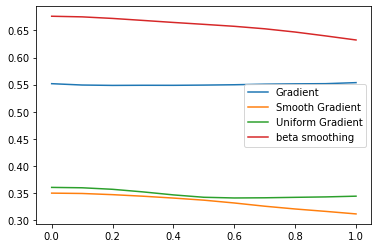

In [80]:
plt.plot(np.arange(0.0, 1.1, 0.1), gini_grad / 50, label="Gradient")
plt.plot(np.arange(0.0, 1.1, 0.1), gini_sg / 50, label="Smooth Gradient")
plt.plot(np.arange(0.0, 1.1, 0.1), gini_ug / 50, label="Uniform Gradient")
plt.plot(np.arange(0.0, 1.1, 0.1), gini_softplus / 50, label="beta smoothing")
plt.legend();

In [82]:
print("dG(gradient): ", (gini_grad[-1] - gini_grad[0])/50)
print("dG(smooth gradient): ", (gini_sg[-1] - gini_sg[0])/50)
print("dG(uniform gradient): ", (gini_ug[-1] - gini_ug[0])/50)
print("dG(softplus + gradient): ", (gini_softplus[-1] - gini_softplus[0])/50)

dG(gradient):  0.001932345189687723
dG(smooth gradient):  -0.038323716405842666
dG(uniform gradient):  -0.016172141664957066
dG(softplus + gradient):  -0.04375607295059112


### Comparing gini index of different methods

In [ ]:
np.random.seed(seed=2)
torch.random.manual_seed(seed=2)
torch.cuda.random.manual_seed(seed=2)

gini_grad = []
gini_sg = []
gini_ug = []
gini_softplus = []
dataiter = iter(test_loader)
for i in range(1000):
    if i%100 == 0:
        print(i)
    model = torchvision.models.vgg16(pretrained=True).to(device)
    model = model.eval()
    images, labels = next(dataiter)
    a = np.random.randint(32)
    x = normalizer.forward(images[a].unsqueeze(0)).to(device)
    idx = model(x).argmax()
    sigma = (torch.max(x) - torch.min(x)).item() * 0.2 
    #######
    expl_grad = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
    expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
    expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
    #######
    gini_grad.append(gini(expl_grad.flatten()))
    gini_sg.append(gini(expl_sg.flatten()))
    gini_ug.append(gini(expl_ug.flatten()))
    del expl_grad
    del expl_sg
    del expl_ug
    torch.cuda.empty_cache()
    ########softplus###########
    model = convert_relu_to_softplus(model, beta=0.8)
    ######
    expl_softplus = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
    gini_softplus.append(gini(expl_softplus.flatten()))
    del expl_softplus
    torch.cuda.empty_cache()


0


/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


100
200
300
400


In [17]:
len(gini_softplus)

1000

In [19]:
print("G(gradient): {} +- {}".format(np.mean(gini_grad), np.std(gini_grad)))
print("G(smooth gradient): {} +- {}".format(np.mean(gini_sg), np.std(gini_sg)))
print("G(uniform gradient): {} +- {}".format(np.mean(gini_ug), np.std(gini_ug)))
print("G(softplus + gradient): {} +- {}".format(np.mean(gini_softplus), np.std(gini_softplus)))

G(gradient): 0.5581555852013044 +- 0.037901076918028
G(smooth gradient): 0.33975813780945574 +- 0.05287098451031109
G(uniform gradient): 0.351338140420653 +- 0.058279079108656526
G(softplus + gradient): 0.6566833715473854 +- 0.06765885550303812


In [265]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()
# images, labels = next(dataiter)
a = np.random.randint(1024)
x = normalizer.forward(images[a].unsqueeze(0)).to(device)
idx = model(x).argmax()
sigma = (torch.max(x) - torch.min(x)).item() * 0.2

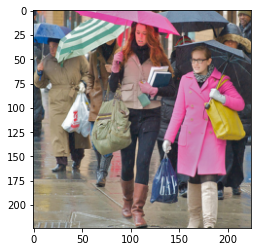

In [266]:
plt.imshow(torch_to_image(x, data_mean, data_std))

In [267]:
print(labels[a], idx)

tensor(879) tensor(879, device='cuda:0')


In [268]:
expl_grad = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
expl_sg = get_expl(model, x, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
expl_ug = get_expl(model, x, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
#######
gini_grad = gini(expl_grad.flatten())
gini_sg = gini(expl_sg.flatten())
gini_ug = gini(expl_ug.flatten())
torch.cuda.empty_cache()
########softplus###########
model = convert_relu_to_softplus(model, beta=0.8)
######
expl_softplus = get_expl(model, x, "saliency", desired_index=idx).detach().cpu()
gini_softplus = gini(expl_softplus.flatten())
torch.cuda.empty_cache()

/home/ahmad/anaconda3/envs/pytorch_robust_expls/lib/python3.9/site-packages/captum/_utils/gradient.py:56: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


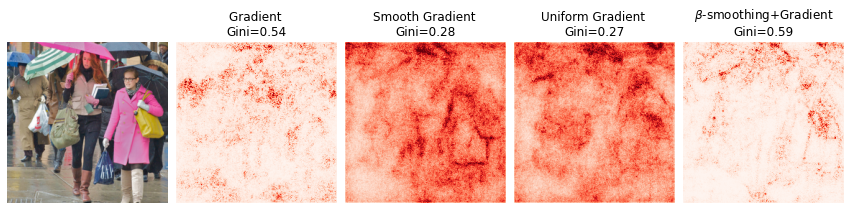

In [270]:
fig, ax = plt.subplots(1,5, figsize=(15, 3))
ax[0].imshow(torch_to_image(x, data_mean, data_std))

viz.visualize_image_attr(np.transpose(expl_grad.squeeze().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1]), use_pyplot=False)
ax[1].set_title("Gradient \nGini={:.2f}".format(gini_grad))
viz.visualize_image_attr(np.transpose(expl_sg.squeeze().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2]), use_pyplot=False)
ax[2].set_title("Smooth Gradient \nGini={:.2f}".format(gini_sg))
viz.visualize_image_attr(np.transpose(expl_ug.squeeze().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[3]), use_pyplot=False)
ax[3].set_title("Uniform Gradient \nGini={:.2f}".format(gini_ug))
viz.visualize_image_attr(np.transpose(expl_softplus.squeeze().numpy(), (1,2,0)),
                             np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[4]), use_pyplot=False)
ax[4].set_title(r"$\beta$-smoothing+Gradient"+"\nGini={:.2f}".format(gini_softplus))
for i in range(len(ax)):
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.05)
plt.savefig("gini_comparison_umbrella.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05)

tensor([[[[1.8113e-04, 1.6038e-06, 1.7926e-05,  ..., 1.2892e-03,
           2.4085e-03, 1.2559e-03],
          [2.2010e-05, 1.1440e-03, 6.5623e-04,  ..., 4.4394e-04,
           1.7547e-03, 1.1736e-04],
          [5.6466e-04, 8.7330e-04, 2.1827e-04,  ..., 9.4172e-04,
           1.5238e-03, 1.6824e-03],
          ...,
          [1.0103e-04, 7.4553e-05, 1.1691e-04,  ..., 4.9821e-04,
           1.3343e-03, 1.3972e-03],
          [1.0074e-04, 1.9674e-04, 8.2988e-05,  ..., 3.8383e-04,
           3.9012e-04, 3.5923e-04],
          [2.1973e-05, 5.4650e-05, 1.5845e-04,  ..., 3.0292e-04,
           9.1909e-04, 1.9486e-04]],

         [[1.3181e-04, 7.5332e-04, 6.9008e-04,  ..., 9.1771e-04,
           2.0577e-03, 2.3259e-03],
          [5.1909e-04, 2.4702e-03, 1.6128e-03,  ..., 2.6347e-03,
           1.4279e-03, 2.1937e-03],
          [1.1972e-03, 1.4477e-03, 5.3009e-05,  ..., 4.7153e-03,
           6.9162e-03, 4.7785e-04],
          ...,
          [6.2205e-05, 7.2715e-05, 1.3116e-04,  ..., 8.8701

### adding a small object to an image

In [ ]:
x_pineapple = load_image(data_mean, data_std, device, "../sample_imagenet/sample_0_pineapple.jpg")
x_apple = load_image(data_mean, data_std, device, "sample_0_apple.jpg")
x_elephant = load_image(data_mean, data_std, device, "sample_0_elephant.jpg")
fig, ax = plt.subplots(1,3, figsize=(6,2))
ax[0].imshow(torch_to_image(x_pineapple, data_mean, data_std))
ax[1].imshow(torch_to_image(x_apple, data_mean, data_std))
ax[2].imshow(torch_to_image(x_elephant, data_mean, data_std))
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

In [ ]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

In [ ]:
model(x_elephant).argmax()

In [ ]:
idx = model(x).argmax()
idx

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(10,6))
ax[0,0].imshow(torch_to_image(x_pineapple, data_mean, data_std))
ax[1,0].imshow(torch_to_image(x_apple, data_mean, data_std))
ax[2,0].imshow(torch_to_image(x_elephant, data_mean, data_std))

for i,img in enumerate([x_pineapple, x_apple, x_elephant]):
    x_expl_grad = get_expl(model, img, "saliency", desired_index=idx).detach().cpu()
    viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[i,1]), use_pyplot=False)
    del x_expl_grad
    torch.cuda.empty_cache()

for i,img in enumerate([x_pineapple, x_apple, x_elephant]):
    x_expl_sg = get_expl(model, img, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
    viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[i,2]), use_pyplot=False)
    del x_expl_sg
    torch.cuda.empty_cache()

for i,img in enumerate([x_pineapple, x_apple, x_elephant]):
    x_expl_ug = get_expl(model, img, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
    viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[i,3]), use_pyplot=False)
    del x_expl_ug
    torch.cuda.empty_cache()

##########softplus###########
model = convert_relu_to_softplus(model, beta=0.8)
for i,img in enumerate([x_pineapple, x_apple, x_elephant]):
    x_expl_softplus = get_expl(model, img, "saliency", desired_index=idx).detach().cpu()
    viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[i,4]), use_pyplot=False)
    del x_expl_softplus
    torch.cuda.empty_cache()

ax[0,1].set_title("Gradient", fontsize=12)
ax[0,2].set_title("Smooth Grad", fontsize=12)
ax[0,3].set_title("Uniform Grad", fontsize=12)
ax[0,4].set_title("Softplus", fontsize=12)
plt.subplots_adjust(wspace=0.01, hspace=0.01)
for i in range(3):
    for j in range(5):
        ax[i,j].axis('off')
plt.savefig("added_object_expl.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

### Grad-CAM

In [ ]:
a = np.random.randint(1024, size=7)
a

In [ ]:
#grad-cam
sys.path.append("../../pytorch-grad-cam/")
from gradcam import GradCam, preprocess_image, show_cam_on_image
import cv2

model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

images = ["../sample_imagenet_1/sample_5.jpg",
#          "../sample_imagenet_1/sample_8.jpg",
#          "../sample_imagenet_1/sample_12.jpg",
          "../sample_imagenet_1/sample_11.jpg",
          "../sample_imagenet_1/sample_19.jpg",
         ]

example_images = []
for i in a:
    example_images.append(normalizer.forward(images[i].unsqueeze(0)).to(device))


fig, ax = plt.subplots(7, 3, figsize=(6,14))

for i, img in enumerate(example_images):
#     img = load_image(data_mean, data_std, device, img_path)
    ax[i, 0].imshow(torch_to_image(img, data_mean, data_std))
    
grad_cam = GradCam(model=model, feature_module=model.features, \
                       target_layer_names=["28"], use_cuda=True)
example_labels = []
for i, img in enumerate(example_images):
#     img = load_image(data_mean, data_std, device, img_path)
    example_labels.append(model(img).argmax())
    grayscale_cam = grad_cam(img)
    cam = show_cam_on_image(torch_to_image(img, data_mean, data_std), grayscale_cam)
    ax[i, 1].imshow(cam[:, :, ::-1])
    
model = convert_relu_to_softplus(model, beta=0.8)
grad_cam = GradCam(model=model, feature_module=model.features, \
                       target_layer_names=["28"], use_cuda=True)

for i, img in enumerate(example_images):
#     img = load_image(data_mean, data_std, device, img_path)
    grayscale_cam = grad_cam(img, target_category=example_labels[i])
    cam = show_cam_on_image(torch_to_image(img, data_mean, data_std), grayscale_cam)
    ax[i, 2].imshow(cam[:, :, ::-1])
    
ax[0, 1].set_title("ReLU net", fontsize=12)
ax[0, 2].set_title("Softplus net",fontsize=12)

for i in range(7):
    for j in range(3):
        ax[i,j].axis('off')

tags = ["joystick", "combination lock", "polar bear", "croquet ball", "Italian greyhound", "trombone", "bustard"]
for i in range(1,8):
    fig.text(0.12, 0.175 + 0.107*(i-1), tags[::-1][i-1], style = 'oblique', fontsize = 12, horizontalalignment ='right')
# fig.text(0.12, 0.5, 'Whiptail Lizard', style = 'oblique', fontsize = 12, horizontalalignment ='right')
# fig.text(0.12, 0.25, 'Grand Piano', style = 'oblique', fontsize = 12, horizontalalignment ='right')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("gradcam_softplus_more_examples.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

In [ ]:
x_cow = load_image(data_mean, data_std, device, "dog_snow.jpeg")
plt.imshow(torch_to_image(x_cow, data_mean, data_std))
plt.axis('off')
plt.savefig("dog_snow.jpg", bbox_inches='tight', pad_inches=0.05)

In [ ]:
#grad-cam
sys.path.append("../../pytorch-grad-cam/")
from gradcam import GradCam, preprocess_image, show_cam_on_image
import cv2

model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

In [ ]:
model(x_cow).argmax()

In [ ]:
grad_cam = GradCam(model=model, feature_module=model.features, \
                       target_layer_names=["28"], use_cuda=True)
grayscale_cam = grad_cam(x_cow, target_category=500)
cam = show_cam_on_image(torch_to_image(x_cow, data_mean, data_std), grayscale_cam)
plt.imshow(cam[:, :, ::-1])
plt.axis('off')
plt.savefig("dog_pred.jpg", bbox_inches='tight', pad_inches=0.05)

In [ ]:
# grayscale_cam*=1.1

In [ ]:
# cam = show_cam_on_image(torch_to_image(x_cow, data_mean, data_std), grayscale_cam)
plt.imshow(cam)